In [1]:
#%matplotlib
%matplotlib inline
import numpy
import matplotlib.pyplot as plt
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import math, gillespy2
from gillespy2.solvers.cpp.ssa_c_solver import SSACSolver
from gillespy2.solvers.numpy.basic_ode_solver import BasicODESolver
from scipy import stats

In [2]:
class DayModel(gillespy2.Model):
    def __init__(self, parameter_values=None, init_v=0, spore=1.61e9, macrophage=1e6):
        # initialize
        gillespy2.Model.__init__(self, name="Macrophage")
        
        # species
        #S_ = gillespy2.Species(name='S_', initial_value=3.256e6) # low = 4e3; mid = 2e4; high = 1e7
        S_ = gillespy2.Species(name='S_', initial_value=spore) # low = 4e3; mid = 2e4; high = 1e7
        
        #A_ = gillespy2.Species(name='A_', initial_value=1e6) # A = Sa/(k2*S+MuA)
        A_ = gillespy2.Species(name='A_', initial_value=macrophage) # A = Sa/(k2*S+MuA)
        
        H1 = gillespy2.Species(name='H1', initial_value=0)
        H2 = gillespy2.Species(name='H2', initial_value=0)
        H3 = gillespy2.Species(name='H3', initial_value=0)
        H4 = gillespy2.Species(name='H4', initial_value=0)
        H5 = gillespy2.Species(name='H5', initial_value=0)
        H6 = gillespy2.Species(name='H6', initial_value=0)
        
        HLN1 = gillespy2.Species(name='HLN1', initial_value=0)
        HLN2 = gillespy2.Species(name='HLN2', initial_value=0)
        HLN3 = gillespy2.Species(name='HLN3', initial_value=0)
        HLN4 = gillespy2.Species(name='HLN4', initial_value=0)
        HLN5 = gillespy2.Species(name='HLN5', initial_value=0)
        HLN6 = gillespy2.Species(name='HLN6', initial_value=0)
        
        self.add_species([S_,A_,H1,H2,H3,H4,H5,H6,HLN1,HLN2,HLN3,HLN4,HLN5,HLN6])
        
        # parameters        
        # rate of phagocytosis
        k2 = gillespy2.Parameter(name='k2', expression=1e-10)
        
        # migration to TMLN
        k3 = gillespy2.Parameter(name='k3', expression=0.05)
        
        self.add_parameter([k2,k3])
        
        # reactions
        R1 = gillespy2.Reaction(
            name='R1',
            reactants={S_:1, A_:1},
            products={H1:1},
            rate=k2
        )
        
        R2 = gillespy2.Reaction(
            name='R2',
            reactants={S_:1, H1:1},
            products={H2:1},
            rate=k2
        )
        
        R3 = gillespy2.Reaction(
            name='R3',
            reactants={S_:1, H2:1},
            products={H3:1},
            rate=k2
        )
        
        R4 = gillespy2.Reaction(
            name='R4',
            reactants={S_:1, H3:1},
            products={H4:1},
            rate=k2
        )
        
        R5 = gillespy2.Reaction(
            name='R5',
            reactants={S_:1, H4:1},
            products={H5:1},
            rate=k2
        )
        
        R6 = gillespy2.Reaction(
            name='R6',
            reactants={S_:1, H5:1},
            products={H6:1},
            rate=k2
        )
        
        # To the lung
        R7 = gillespy2.Reaction(
            name='R7',
            reactants={H1:1},
            products={HLN1:1},
            rate=k3
        )
        
        R8 = gillespy2.Reaction(
            name='R8',
            reactants={H2:1},
            products={HLN2:1},
            rate=k3
        )
        
        R9 = gillespy2.Reaction(
            name='R9',
            reactants={H3:1},
            products={HLN3:1},
            rate=k3
        )
        
        R10 = gillespy2.Reaction(
            name='R10',
            reactants={H4:1},
            products={HLN4:1},
            rate=k3
        )
        
        R11 = gillespy2.Reaction(
            name='R11',
            reactants={H5:1},
            products={HLN5:1},
            rate=k3
        )
        
        R12 = gillespy2.Reaction(
            name='R12',
            reactants={H6:1},
            products={HLN6:1},
            rate=k3
        )
                
        self.add_reaction([R1,R2,R3,R4,R5,R6,R7,R8,R9,R10,R11,R12])
        t = numpy.linspace(0,200,21)
        self.timespan(t)
        #print(t)

In [3]:
def get_mean(results):
    num =  (
        (1*results['HLN1'][-1]) +
        (2*results['HLN2'][-1]) +
        (3*results['HLN3'][-1]) +
        (4*results['HLN4'][-1]) +
        (5*results['HLN5'][-1]) +
        (6*results['HLN6'][-1])
    )

    div = (
        results['HLN1'][-1] +
        results['HLN2'][-1] +
        results['HLN3'][-1] +
        results['HLN4'][-1] +
        results['HLN5'][-1] +
        results['HLN6'][-1]
    )
    
    weighted_avg = num / div
    return weighted_avg

def get_std(results):
    num =  (
        (1*results['HLN1'][-1]) +
        (2*results['HLN2'][-1]) +
        (3*results['HLN3'][-1]) +
        (4*results['HLN4'][-1]) +
        (5*results['HLN5'][-1]) +
        (6*results['HLN6'][-1])
    )
    
    num_sq =  (
        (1*results['HLN1'][-1]) +
        (4*results['HLN2'][-1]) +
        (9*results['HLN3'][-1]) +
        (16*results['HLN4'][-1]) +
        (25*results['HLN5'][-1]) +
        (36*results['HLN6'][-1])
    )

    div = (
        results['HLN1'][-1] +
        results['HLN2'][-1] +
        results['HLN3'][-1] +
        results['HLN4'][-1] +
        results['HLN5'][-1] +
        results['HLN6'][-1]
    )
    
    weighted_avg = num / div
    var_x = (num_sq / div) - weighted_avg**2
    return numpy.sqrt(var_x)

def get_sem(results):
    n = (
        results['HLN1'][-1] +
        results['HLN2'][-1] +
        results['HLN3'][-1] +
        results['HLN4'][-1] +
        results['HLN5'][-1] +
        results['HLN6'][-1]
    )
    return get_std(results)/numpy.sqrt(n)

In [4]:
model_4_4 = DayModel(macrophage=1.27E+08, spore=1.83E+09)
%time results_4_4 = model_4_4.run(solver=BasicODESolver)
%time mean_of_model_4_4 = get_mean(results_4_4[0])
mean_of_model_4_4

CPU times: user 62.5 ms, sys: 0 ns, total: 62.5 ms
Wall time: 54 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 13.6 µs


3.3622306328426506

In [5]:
model1 = DayModel(macrophage=1.15E+08, spore=1.83E+09)
%time results1 = model1.run(solver=BasicODESolver)
%time mean_of_model1 = get_mean(results1[0])
mean_of_model1

CPU times: user 62.5 ms, sys: 0 ns, total: 62.5 ms
Wall time: 54.1 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 14.8 µs


3.382484724005341

In [6]:
model_6_5 = DayModel(macrophage=1.44E+09, spore=3.79E+09)
%time results_6_5 = model_6_5.run(solver=BasicODESolver)
%time mean_of_model_6_5 = get_mean(results_6_5[0])
mean_of_model_6_5

CPU times: user 62.5 ms, sys: 0 ns, total: 62.5 ms
Wall time: 55.8 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 14.3 µs


2.5889930194196924

In [7]:
model_6_6 = DayModel(macrophage=1.44E+09, spore=7.85E+09)
%time results_6_6 = model_6_6.run(solver=BasicODESolver)
%time mean_of_model_6_6 = get_mean(results_6_6[0])
mean_of_model_6_6

CPU times: user 62.5 ms, sys: 0 ns, total: 62.5 ms
Wall time: 69 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 12.6 µs


4.47733696064419

In [8]:
model_7_7 = DayModel(macrophage=4.83E+09, spore=1.62E+10)
%time results_7_7 = model_7_7.run(solver=BasicODESolver)
%time mean_of_model_7_7 = get_mean(results_7_7[0])
mean_of_model_7_7

CPU times: user 46.9 ms, sys: 0 ns, total: 46.9 ms
Wall time: 59.5 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 14.5 µs


3.424779154990626

In [9]:
model_8_8 = DayModel(macrophage=1.62E+10, spore=3.36E+10)
%time results_8_8 = model_8_8.run(solver=BasicODESolver)
%time mean_of_model_8_8 = get_mean(results_8_8[0])
mean_of_model_8_8

CPU times: user 93.8 ms, sys: 0 ns, total: 93.8 ms
Wall time: 88.4 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 13.6 µs


2.3565960205479386

In [10]:
model_9_9 = DayModel(macrophage=5.46E+10, spore=6.95E+10)
%time results_9_9 = model_9_9.run(solver=BasicODESolver)
%time mean_of_model_9_9 = get_mean(results_9_9[0])
mean_of_model_9_9

CPU times: user 156 ms, sys: 0 ns, total: 156 ms
Wall time: 152 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 14.5 µs


1.7641657802703286

In [11]:
model_9_10 = DayModel(macrophage=5.46E+10, spore=1.44E+11)
%time results_9_10 = model_9_10.run(solver=BasicODESolver)
%time mean_of_model_9_10 = get_mean(results_9_10[0])
mean_of_model_9_10

CPU times: user 125 ms, sys: 0 ns, total: 125 ms
Wall time: 110 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 15 µs


2.831051466258199

In [12]:
model_10_11 = DayModel(macrophage=1.83E+11, spore=2.98E+11)
%time results_10_11 = model_10_11.run(solver=BasicODESolver)
%time mean_of_model_10_11 = get_mean(results_10_11[0])
mean_of_model_10_11

CPU times: user 141 ms, sys: 0 ns, total: 141 ms
Wall time: 138 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 14.3 µs


2.023967408773207

In [90]:
model_10_12 = DayModel(macrophage=1.8E+11, spore=6.16E+11)
%time results_10_12 = model_10_12.run(solver=BasicODESolver)
%time mean_of_model_10_12 = get_mean(results_10_12[0])
mean_of_model_10_12

CPU times: user 156 ms, sys: 0 ns, total: 156 ms
Wall time: 153 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 18.1 µs


3.5242670097675406

In [91]:
results_10_12

[{'time': [0.0,
   10.0,
   20.0,
   30.0,
   40.0,
   50.0,
   60.0,
   70.0,
   80.0,
   90.0,
   100.0,
   110.0,
   120.0,
   130.0,
   140.0,
   150.0,
   160.0,
   170.0,
   180.0,
   190.0],
  'S_': [616000000000.0,
   -1.1882542071954578e-09,
   1.4199636269498184e-12,
   2.1964217448641963e-10,
   1.0030374933326836e-10,
   4.953927880001017e-13,
   2.136163787119444e-09,
   1.691218131344505e-11,
   -5.309732283122172e-09,
   -4.803532857643774e-09,
   -1.6141952082902146e-11,
   4.378651782245802e-12,
   -6.523014616181686e-10,
   2.1112199377089436e-09,
   1.0658789545616847e-12,
   1.836059463073631e-11,
   -2.2333678013331916e-10,
   -1.6044956303883599e-10,
   4.756760336804988e-12,
   -1.0351119938459314e-11],
  'A_': [180000000000.0,
   5211904773.12862,
   5211904773.12862,
   5211904773.12862,
   5211904773.12862,
   5211904773.12862,
   5211904773.12862,
   5211904773.12862,
   5211904773.12862,
   5211904773.12862,
   5211904773.12862,
   5211904773.12862,
   52119

In [14]:
model_10_13 = DayModel(macrophage=1.83E+11, spore=1.27E+12)
%time results_10_13 = model_10_13.run(solver=BasicODESolver)
%time mean_of_model_10_13 = get_mean(results_10_13[0])
mean_of_model_10_13

CPU times: user 93.8 ms, sys: 15.6 ms, total: 109 ms
Wall time: 98.7 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 15.3 µs


3.0000000000000004

In [15]:
model_11_14 = DayModel(macrophage=6.16E+11, spore=2.64E+12)
%time results_11_14 = model_11_14.run(solver=BasicODESolver)
%time mean_of_model_11_14 = get_mean(results_11_14[0])
mean_of_model_11_14

CPU times: user 172 ms, sys: 0 ns, total: 172 ms
Wall time: 169 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 13.4 µs


4.326581558538036

In [16]:
model_11_15 = DayModel(macrophage=6.16E+11, spore=5.46E+12)
%time results_11_15 = model_11_15.run(solver=BasicODESolver)
%time mean_of_model_11_15 = get_mean(results_11_15[0])
mean_of_model_11_15

CPU times: user 125 ms, sys: 0 ns, total: 125 ms
Wall time: 119 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 12.6 µs


5.271127216836251

In [17]:
model_12_16 = DayModel(macrophage=2.07E+12, spore=1.13E+13)
%time results_12_16 = model_12_16.run(solver=BasicODESolver)
%time mean_of_model_12_16 = get_mean(results_12_16[0])
mean_of_model_12_16

CPU times: user 93.8 ms, sys: 0 ns, total: 93.8 ms
Wall time: 93.6 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 13.8 µs


5.271127216836251

In [18]:
model_13_17 = DayModel(macrophage=6.95E+12, spore=2.34E+13)
%time results_13_17 = model_13_17.run(solver=BasicODESolver)
%time mean_of_model_13_17 = get_mean(results_13_17[0])
mean_of_model_13_17

CPU times: user 109 ms, sys: 0 ns, total: 109 ms
Wall time: 118 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 14.5 µs


5.271127216836251

In [19]:
model_13_18 = DayModel(macrophage=6.95E+12, spore=4.83E+13)
%time results_13_18 = model_13_18.run(solver=BasicODESolver)
%time mean_of_model_13_18 = get_mean(results_13_18[0])
mean_of_model_13_18

CPU times: user 93.8 ms, sys: 0 ns, total: 93.8 ms
Wall time: 95.9 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 106 µs


/home/george/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


nan

In [20]:
model_14_19 = DayModel(macrophage=2.34E+13, spore=1.00E+14)
%time results_14_19 = model_14_19.run(solver=BasicODESolver)
%time mean_of_model_14_19 = get_mean(results_14_19[0])
mean_of_model_14_19

CPU times: user 109 ms, sys: 0 ns, total: 109 ms
Wall time: 104 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 15.5 µs


3.0000000000000004

In [21]:
# THIS IS ONE OF THE OUTLIERS
model_15_15 = DayModel(macrophage=7.85E+13, spore=5.46E+12)
%time results_15_15 = model_15_15.run(solver=BasicODESolver)
%time mean_of_model_15_15 = get_mean(results_15_15[0])
mean_of_model_15_15

CPU times: user 141 ms, sys: 15.6 ms, total: 156 ms
Wall time: 130 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 13.8 µs


1.0351799695559116

In [22]:
# THIS IS ONE OF THE OUTLIERS
model_18_18 = DayModel(macrophage=2.48E+15, spore=4.83e13)
%time results_18_18 = model_18_18.run(solver=BasicODESolver)
%time mean_of_model_18_18 = get_mean(results_18_18[0])
mean_of_model_18_18

CPU times: user 125 ms, sys: 0 ns, total: 125 ms
Wall time: 133 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 16 µs


3.0000000000000004

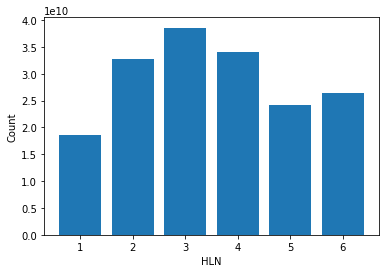

Mean: 	3.5242670097675406
STD:  	1.5657298021548314
SEM:  	3.7452185482086874e-06


In [53]:
res = results_10_12[0]
data = [
    res['HLN1'][-1],
    res['HLN2'][-1],
    res['HLN3'][-1],
    res['HLN4'][-1],
    res['HLN5'][-1],
    res['HLN6'][-1]
]
x = [1,2,3,4,5,6]


mean = get_mean(res)
sd = get_std(res)
sem = get_sem(res)

plt.bar(x,data)
plt.xlabel('HLN')
plt.ylabel('Count')
plt.show()

# plt.hist(data3, bins=x,edgecolor="black")
# plt.xlabel('HLN')
# plt.ylabel('Count')
# plt.show()

print("Mean: \t{}".format(mean))
print("STD:  \t{}".format(sd))
print("SEM:  \t{}".format(sem))

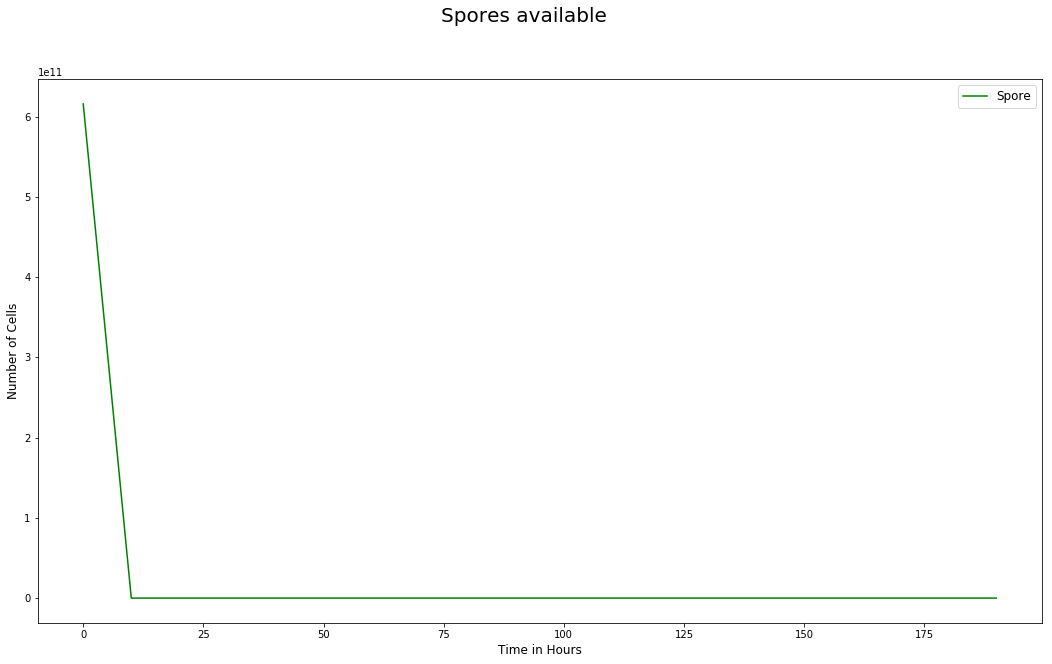

In [54]:
fig = plt.figure(figsize=(18,10))
fig.suptitle("Spores available", fontsize=20)

plt.plot(results_10_12[0]['time'], results_10_12[0]['S_'], 'g-', label='Spore')

plt.xlabel("Time in Hours", fontsize=12)
plt.ylabel("Number of Cells", fontsize=12)
plt.legend(loc='best', fontsize=12)
# print("Initial spores: {}".format(results['S_'][0]))
# print("Spores remaining: {}".format(results['S_'][-1]))
# print("Spores at 5 hours: {}".format(results['S_'][100]))


Lung Hosts at end:
H1: 1385985.1085153685
H2: 2450804.8544495883
H3: 2892147.0248012724
H4: 2560372.9648229005
H5: 1813507.6928325826
H6: 1994770.6710047019


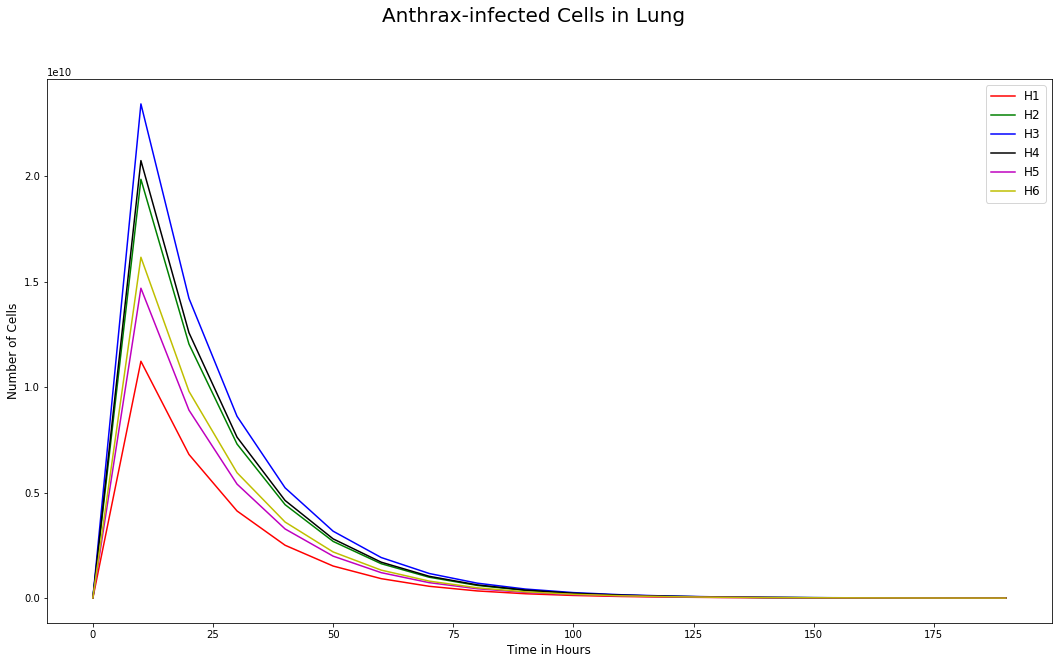

In [55]:
res = results_10_12[0]
fig = plt.figure(figsize=(18,10))
fig.suptitle("Anthrax-infected Cells in Lung", fontsize=20)

#plt.plot(results[0]['time'], results[0]['S_'], 'g-', label='Spore')
plt.plot(res['time'], res['H1'], 'r-', label='H1')
plt.plot(res['time'], res['H2'], 'g-', label='H2')
plt.plot(res['time'], res['H3'], 'b-', label='H3')
plt.plot(res['time'], res['H4'], 'k-', label='H4')
plt.plot(res['time'], res['H5'], 'm-', label='H5')
plt.plot(res['time'], res['H6'], 'y-', label='H6')

plt.xlabel("Time in Hours", fontsize=12)
plt.ylabel("Number of Cells", fontsize=12)
plt.legend(loc='best', fontsize=12)

print("Lung Hosts at end:")
print("H1: {}".format(res['H1'][-1]))
print("H2: {}".format(res['H2'][-1]))
print("H3: {}".format(res['H3'][-1]))
print("H4: {}".format(res['H4'][-1]))
print("H5: {}".format(res['H5'][-1]))
print("H6: {}".format(res['H6'][-1]))




k2 = 1.00e-10, k3 = 5.00e-02
Lung Hosts at end:
H1: 1385985.1085153685
H2: 2450804.8544495883
H3: 2892147.0248012724
H4: 2560372.9648229005
H5: 1813507.6928325826
H6: 1994770.6710047019
Lymph Node Hosts at end:
HLN1: 18682509027.97656
HLN2: 32803860376.555374
HLN3: 38586671360.367424
HLN4: 34095093151.233368
HLN5: 24118040491.896923
HLN6: 26488823230.52509


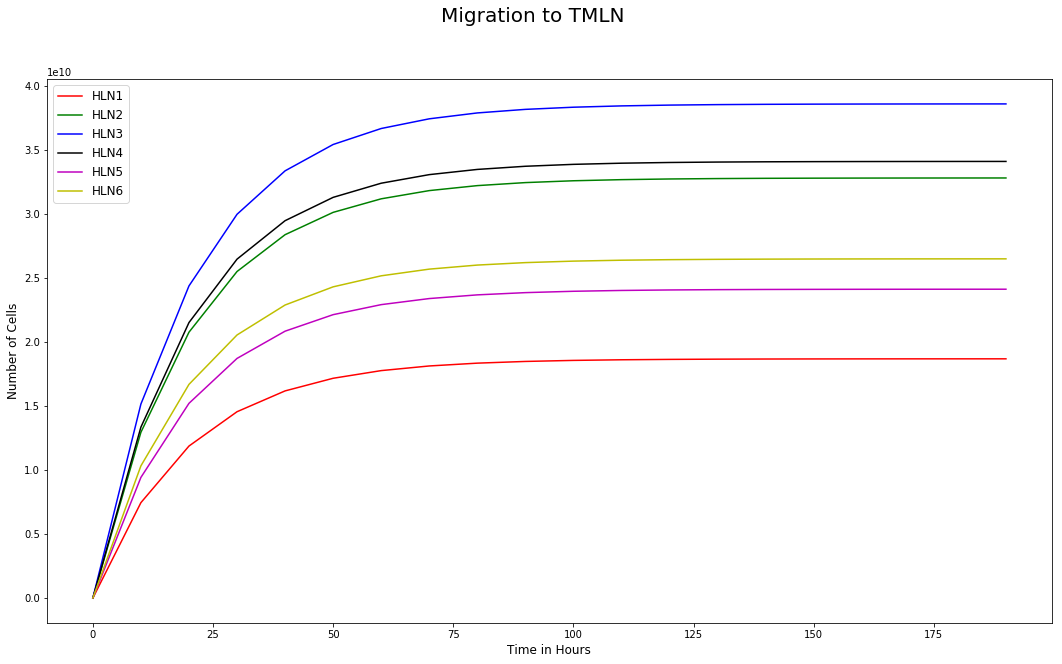

In [56]:
fig = plt.figure(figsize=(18,10))
fig.suptitle("Migration to TMLN", fontsize=20)
res = results_10_12[0]

#plt.plot(results[0]['time'], results[0]['S_'], 'b', label='Spores')
plt.plot(res['time'], res['HLN1'], 'r-', label='HLN1')
plt.plot(res['time'], res['HLN2'], 'g-', label='HLN2')
plt.plot(res['time'], res['HLN3'], 'b-', label='HLN3')
plt.plot(res['time'], res['HLN4'], 'k-', label='HLN4')
plt.plot(res['time'], res['HLN5'], 'm-', label='HLN5')
plt.plot(res['time'], res['HLN6'], 'y-', label='HLN6')

plt.xlabel("Time in Hours", fontsize=12)
plt.ylabel("Number of Cells", fontsize=12)
plt.legend(loc='best', fontsize=12)

print("k2 = {:.2e}, k3 = {:.2e}".format(float(model_10_12.listOfParameters['k2'].expression), float(model_10_12.listOfParameters['k3'].expression)))

print("Lung Hosts at end:")
print("H1: {}".format(res['H1'][-1]))
print("H2: {}".format(res['H2'][-1]))
print("H3: {}".format(res['H3'][-1]))
print("H4: {}".format(res['H4'][-1]))
print("H5: {}".format(res['H5'][-1]))
print("H6: {}".format(res['H6'][-1]))

print("Lymph Node Hosts at end:")
print("HLN1: {}".format(res['HLN1'][-1]))
print("HLN2: {}".format(res['HLN2'][-1]))
print("HLN3: {}".format(res['HLN3'][-1]))
print("HLN4: {}".format(res['HLN4'][-1]))
print("HLN5: {}".format(res['HLN5'][-1]))
print("HLN6: {}".format(res['HLN6'][-1]))